# Titanic Kaggle challenge

The aim of this project is to build a classification model from the data of 891 passengers of the Titanic in order to predict the survival of another 418 passengers. 

My aim was to implement the logistic regression algorithm in different ways, and see the performance for each option.

There are 3 main sections:
- **Understanding the data**: Analysing the meaning of each feature and getting a general comprehension about the data.
- **Preparing the data**: Filling empty data, giving numerical values to categorized data, data binning for numerical features and removal of features.
- **Modelling with logistic regression**, with 2 approaches:
    - First model: Coded from scratch.
    - Second model: Built with the scikit-learn library.

These models had an accuracy for the challenge data of:
- First model: 77.751 %
- Second model (sk-learn): 76.555 %

The parameters of the model showed that:
- **Factors most positive for survival** were, in order, being under 10 years old, particularly under 5, being a woman and being part of the first class passengers. This makes sense, as during the titanic tragedy small children and women were prioritized for the saving boats. Also third class passenger rooms were at the bottom of the boat so their chances were smaller than first class passengers, whose rooms where in the upper areas and had bigger chances of reaching the boat deck.
- **Negative factors for survival** were, in order, being a male, a third class passenger, and being over 60 years old. Also, having several siblings or children had a negative impact. 

# Table of contents

* [Importing libraries and data](#import)

* [Understanding the data](#understanding)

* [Preparing the data](#preparing)
    * [Numerical features](#numerical)
        * [Age](#age)
        * [Fare](#fare)
        * [Number of siblings/spouses](#sibsp)
        * [Number of parents/children](#parch)
    * [Categorical features](#categorical)
        * [Embarcation port](#embarked)
        * [Passenger class](#pclass)
        * [Sex](#sex)       
    * [Removal of features: Name, Ticket and Cabin](#drop)
    
* [Modelling with logistic regression](#modelling)
    * [Building and training the model](#building)
        * [Learning curve](#curve)
        * [Prediction for the challenge set](#prediction)
    * [With Scikit-learn](#scikit)
        * [Algorithm with default values](#default)
        * [Algorithm with optimized parameter C](#optimized)

## Importing libraries and data <a class="anchor" id="import"></a>

In [82]:
# Libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split

In [83]:
# Importing data
df_titanic = pd.read_csv('train.csv') # Set to train the model
df_prediction = pd.read_csv('test.csv') # Set for the challenge, in which predictions need to be made
print(f"The training set has {df_titanic.shape[0]} samples")
print(f"The challenge set has {df_prediction.shape[0]} samples")

The training set has 891 samples
The challenge set has 418 samples


In [84]:
# Merging both dataframes "df_titanic" and "df_prediction" into "df". Data will be prepared with "df", and split again 
# for the modelling phase
survived_test = np.empty(df_prediction.shape[0])
survived_test.fill(np.nan)
df_prediction["Survived"] = survived_test
df = pd.concat([df_titanic,df_prediction])
df.set_index('PassengerId',inplace=True)

## Understanding the data <a class="anchor" id="understanding"></a>

This table from the Kaggle challenge explains the meaning of each feature: 

| Variable | Definition | Key |
| --- | --- | --- |
survival | Survival | 0 = No, 1 = Yes
pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd
sex | Sex |
Age | Age in years | Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
sibsp | # of siblings/spouses aboard the Titanic |
parch | # of parents/children aboard the Titanic |
ticket | Ticket number |
fare | Passenger fare |
cabin | Cabin number |
embarked | Port of Embarcation | C = Cherbourg, Q = Queenstown, S = Southampton

In [85]:
# Dataframe visualization
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [86]:
# Checking data types and missing values:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


In [87]:
#Statistics of the numerical data: 
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [88]:
## Remove comment to plot the relation of "Survived" with the rest of features

#sns.pairplot(df, hue = "Survived")

In our training data the survival rate is of 38.38%
This plot shows as bars number of passengers for each value of Survived


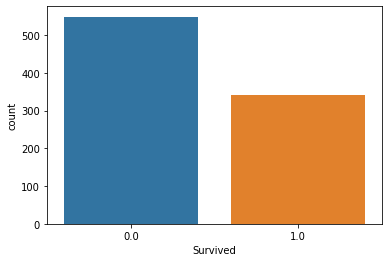

In [89]:
sns.countplot(x = "Survived", data = df)
surv_per = df_titanic["Survived"].sum()*100/df_titanic.shape[0]
print(f"In our training data the survival rate is of {surv_per:.02f}%")
print("This plot shows as bars number of passengers for each value of Survived")

## Preparing the data <a class="anchor" id="preparing"></a>

Some features require analysis and preparation:
- **Age** has 263 missing values out of 1309 (around 20%); to fill them, the titles of each passenger in the **Name** feature will be used as a reference (example: "Master" is used for males under 13). Then data will be binned and one-hot encoded.
- **SibSp** and **Parch** categories need to have their data distribution studied before being one-hot encoded.
- **Embarked** has 2 missing values, which will be filled with the most frequent port, and then one-hot encoded.
- **Fare** range is from 0 to 512.32 pounds: it will be binned and one hot-encoded.

Straighforward one-hot encoding for:
- **Pclass**: 3 categories -> 1st class, 2nd class, 3rd class
- **Sex**: 2 categories -> Male, Female

Removed features:
- **Name**: Useful to fill missing values in **Age**, but not for modelling.
- **Cabin**: Too many missing values, and with some redundancy with Passenger class. It would add several features which would make the model more prone to overfitting.
- **Ticket**: The ticket system is quite erratic and does not give much relevant information. 

In [90]:
# Function used for most features that takes the feature, one-hot encodes it and removes the original column
def categorize(label):
    global df
    # Dummies for "label"
    df_temp = pd.get_dummies(df[label], prefix=label)

    # Merge df with new dummy features
    df = pd.concat([df, df_temp], axis=1)

    # Remove 'label' column from df
    df.drop(label, axis = 1, inplace=True)
    
    return

### Numerical features <a class="anchor" id="numerical"></a>

#### *Age* <a class="anchor" id="age"></a>

In order to estimate the 177 missing values, passenger's **Name** can be taken as reference - most passengers have one of the following 4 titles:
- *Mr*: Men older than 12 years.
- *Mrs*: Married or widowed women.
- *Master*: Men younger than 13 years.
- *Miss*: Female children and unmarried women.

The next cells calculate the <u>average age of people with the same title</u>, which will be used to fill the missing values. 

In [91]:
# Function to remove name of all passengers, keeping only their title
def onlykeeptitle(title):
    global df
    df.loc[df["Name"].str.contains(f"{title}. "),"Name"] = title
    return

# Removal of names for the main titles
for title in ["Mr","Mrs","Miss","Master","Dr"]:
    onlykeeptitle(title)

# Remove unique titles
df.loc[df["Name"].str.contains("Don. "),"Name"] = "Mr"
df.loc[df["Name"].str.contains("Mme. "),"Name"] = "Miss" # Mme. is a traditional french title for women
df.loc[df["Name"].str.contains("Mlle. "),"Name"] = "Mrs" # Mlle. is a traditional french title for unmarried women
df.loc[df["Name"].str.contains("Jonkheer. "),"Name"] = "Mr" # Jonkheer. is a traditional title for low nobility 
df.loc[df["Name"].str.contains("Sir. "),"Name"] = "Mr"
df.loc[df["Name"].str.contains("Ms. "),"Name"] = "Mrs"
df.loc[df["Name"].str.contains("Countess. "),"Name"] = "Mrs"
df.loc[df["Name"].str.contains("Dona. "),"Name"] = "Mrs"
df.loc[df["Name"].str.contains("Capt. "),"Name"] = "Col"
df.loc[df["Name"].str.contains("Col"),"Name"] = "Mr"
df.loc[df["Name"].str.contains("Rev"),"Name"] = "Mr"
df.loc[df["Name"].str.contains("Major"),"Name"] = "Mr"

missing_age = df["Age"].isnull().groupby(df["Name"]).sum().astype(int).reset_index(name="count").set_index("Name").transpose()
print(f"Total of missing entries for each title: ")
missing_age

Total of missing entries for each title: 


Name,Dr,Master,Miss,Mr,Mrs
count,1,8,50,176,28


In [92]:
mean_age = df[["Name","Age"]].groupby(["Name"]).mean().transpose()
print("Average age for each name title:")
mean_age

Average age for each name title:


Name,Dr,Master,Miss,Mr,Mrs
Age,43.571429,5.482642,21.787512,32.659204,36.856322


In [93]:
# Function to replace missing NaN values in "Age" with the corresponding title average 
def fill_age(title):
    global df
    global mean_age
    df.loc[(np.isnan(df["Age"])) & (df["Name"]==title), "Age"] = mean_age.loc["Age",title]
    
for title in ["Dr","Mr","Mrs","Miss","Master"]:
        fill_age(title)

Now that all missing values have been filled, data will be binned:

Text(0.5, 1.0, 'Age bins')

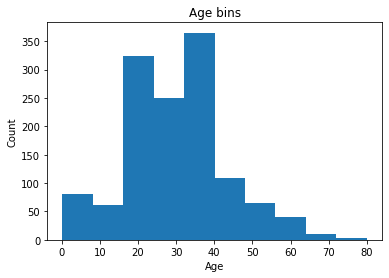

In [94]:
# Histogram of age distribution
plt.hist(df["Age"])

plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age bins")

Ages go from 0.17 to 80, with most passengers between 20 and 40 years old. Data will be binned as *15 intervals of 5 years*: (0-9], (10-19], ..., (65-70],(70 and more]

This options was chosen after studying the Chi-Square P-value for different intervals.:

In [95]:
df.loc[df["Age"]>70,"Age"] = 71 # Prepare data to group passengers over 70 years old in the same category

# Chi-Square P-value
bins = [5*i for i in range(16)]
df["age"] = pd.cut(df["Age"] , bins=bins)
Crosstab_age=pd.crosstab(index=df["age"],columns=df["Survived"])
ChiSq_age = chi2_contingency(Crosstab_age)
print("The P-Value of the Chi-Square Test for 15 intervals is:", ChiSq_age[1])

# Crosstab of number of "Survived" values according to age groups
Crosstab_age=pd.crosstab(index=df['age'],columns=df['Survived'])
print(f"\nNumber of passengers who survived according to their age group:")
Crosstab_age.transpose()

The P-Value of the Chi-Square Test for 15 intervals is: 6.537566557277512e-05

Number of passengers who survived according to their age group:


age,"(0, 5]","(5, 10]","(10, 15]","(15, 20]","(20, 25]","(25, 30]","(30, 35]","(35, 40]","(40, 45]","(45, 50]","(50, 55]","(55, 60]","(60, 65]","(65, 70]","(70, 75]"
Survived,,,,,,,,,,,,,,,
0.0,13,15,8,63,94,66,152,42,31,23,14,11,10,3,4
1.0,31,9,11,33,64,42,55,42,17,16,10,7,4,0,1


In [96]:
# Crosstab of percentage of "Survived" values according to age groups
Crosstab_age_per=pd.crosstab(index=df['age'],columns=df['Survived'], normalize="index")\
.round(2)*100
print(f"Percentage of passengers who survived according to their age group")
Crosstab_age_per.transpose()

Percentage of passengers who survived according to their age group


age,"(0, 5]","(5, 10]","(10, 15]","(15, 20]","(20, 25]","(25, 30]","(30, 35]","(35, 40]","(40, 45]","(45, 50]","(50, 55]","(55, 60]","(60, 65]","(65, 70]","(70, 75]"
Survived,,,,,,,,,,,,,,,
0.0,30.0,62.0,42.0,66.0,59.0,61.0,73.0,50.0,65.0,59.0,58.0,61.0,71.0,100.0,80.0
1.0,70.0,38.0,58.0,34.0,41.0,39.0,27.0,50.0,35.0,41.0,42.0,39.0,29.0,0.0,20.0


In [97]:
categorize("age")

df.drop("Age", axis = 1, inplace=True)

df.rename(columns={"age_(70, 75]":"age_70+"},inplace=True)

#### Fare <a class="anchor" id="fare"></a>

This table shows how fares were organised for the trip:

<center><b>Fare (pounds, 1912 prices)</b></center>

|Class|Minimum|Lower Quartile|Median|Upper Quartile|Maximum|
|---|---|---|---|---|---|
|First|0.00|30.65|60.00|106.43|512.33|
|Second|0.00|13.00|14.50|26.00|73.50|
|Third|0.00|7.75|8.05|15.10|69.55|

Text(0.5, 1.0, 'Fare bins')

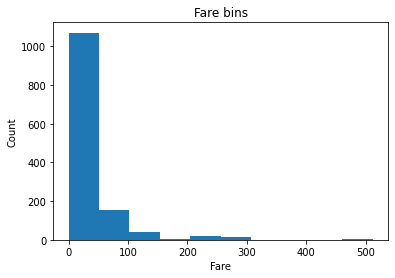

In [98]:
# Histogram of "Fare"
plt.hist(df["Fare"])

plt.xlabel("Fare")
plt.ylabel("Count")
plt.title("Fare bins")

The histogram shows how most fares are between the 0-50 range, and how fares over 100 are scarce. Data will be:
- Binned in intervals of 25:
- Grouped in a same category from 300 value onwards

In [99]:
# Prepare data to group passengers with fare over 300 in the same category
df.loc[df["Fare"]>300,"Fare"] = 301


df["fare"] = pd.cut(df["Fare"] , bins=[25*i for i in range(14)])
print(f"Number of passengers for each fare bin: ")
print(df["fare"].value_counts().sort_index())

Crosstabfare=pd.crosstab(index=df['fare'],columns=df['Survived'],normalize='index')\
.round(2)*100
print('\nPercentage of "Survived" according to fare:')
Crosstabfare.transpose()

Number of passengers for each fare bin: 
(0, 25]       804
(25, 50]      247
(50, 75]       95
(75, 100]      61
(100, 125]     17
(125, 150]     16
(150, 175]     13
(175, 200]      0
(200, 225]     13
(225, 250]      8
(250, 275]     13
(275, 300]      0
(300, 325]      4
Name: fare, dtype: int64

Percentage of "Survived" according to fare:


fare,"(0, 25]","(25, 50]","(50, 75]","(75, 100]","(100, 125]","(125, 150]","(150, 175]","(200, 225]","(225, 250]","(250, 275]","(300, 325]"
Survived,,,,,,,,,,,
0.0,71.0,58.0,44.0,20.0,27.0,11.0,33.0,40.0,33.0,33.0,0.0
1.0,29.0,42.0,56.0,80.0,73.0,89.0,67.0,60.0,67.0,67.0,100.0


In [100]:
categorize("fare")

df.drop("Fare", axis = 1, inplace=True)

df.rename(columns={"fare_(300,325]":"fare_300+"},inplace=True)

#### Number of Siblings/Spouses <a class="anchor" id="sibsp"></a>

Let's have a look at percentage of passengers who survived according to the number of siblings/spouses on board:

In [101]:
# Values for each category
print("Number of passengers for each SibSp category:")
df["SibSp"].value_counts().sort_index().to_frame().transpose()

Number of passengers for each SibSp category:


,0,1,2,3,4,5,8
SibSp,891,319,42,20,22,6,9


In [102]:
print('Percentage of "Survived" according to SibSp:')
CrosstabSibSp=pd.crosstab(index=df['SibSp'],columns=df['Survived'], normalize="index")\
.round(2)*100
CrosstabSibSp.transpose()

Percentage of "Survived" according to SibSp:


SibSp,0,1,2,3,4,5,8
Survived,,,,,,,
0.0,65.0,46.0,54.0,75.0,83.0,100.0,100.0
1.0,35.0,54.0,46.0,25.0,17.0,0.0,0.0


In conclusion: 
- Vast majority of passengers had none or only one sibling/spouse.
- The total of passengers with 5 or more siblings/spouses is low (12 passengers) and all had *Survived* value 0

In order to reduce the number of features, categories from 5 onwards will be merged into one.

In [103]:
# Merge all people with 5+ siblings/spouses in same category
df.loc[df["SibSp"]>5,"SibSp"] = 5

categorize("SibSp")

# Rename column "SibSp_5" to "SibSp_5+", as now it includes all passengers with 5 or more siblings/spouses
df.rename(columns={"SibSp_5":"SibSp_5+"},inplace=True)

#### Number of Parents/Children  <a class="anchor" id="parch"></a>

The study of this feature is similar to the previous one, *SibSp*:

In [104]:
# Values for each category
print("Number of passengers for each Parch category:")
df_titanic["Parch"].value_counts().sort_index()

Number of passengers for each Parch category:


0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: Parch, dtype: int64

In [105]:
print('Percentage of "Survived" according to "Parch":')
CrosstabParch=pd.crosstab(index=df_titanic['Parch'],columns=df_titanic['Survived'], normalize="index")\
.round(2)*100
CrosstabParch.transpose()

Percentage of "Survived" according to "Parch":


Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,66.0,45.0,50.0,40.0,100.0,80.0,100.0
1,34.0,55.0,50.0,60.0,0.0,20.0,0.0


In [106]:
# Merge all people with 6+ parents/children in the same category
df.loc[df["Parch"]>6,"Parch"] = 6

categorize("Parch")

df.rename(columns={"Parch_6":"Parch_6+"},inplace=True)

### Categorical features  <a class="anchor" id="categorical"></a>

#### *Embarked* feature <a class="anchor" id="embarked"></a>

Titanic passengers embarked from 3 different ports: 
- C = Cherbourg 
- Q = Queenstown
- S = Southampton

The 2 missing values will be replaced by the most frequent port, which is Southampton (S), with a 72.44%.

In [107]:
# Percentage of passengers of each port
print(df["Embarked"].value_counts(normalize=True)\
.round(4)*100)

S    69.93
C    20.66
Q     9.41
Name: Embarked, dtype: float64


In [108]:
# Fill the 2 missing values with 'S'
df['Embarked'].fillna('S',inplace=True)

Crosstab_embarked=pd.crosstab(index=df['Embarked'],columns=df['Survived'])
Crosstab_embarked_per=pd.crosstab(index=df['Embarked'],columns=df['Survived'], normalize="index")\
.round(2)*100
print("Number of passengers who survived depending on their embarcation port")
Crosstab_embarked

Number of passengers who survived depending on their embarcation port


Survived,0.0,1.0
Embarked,,
C,75,93
Q,47,30
S,427,219


In [109]:
ChiSq_embark = chi2_contingency(Crosstab_embarked)
print("The P-Value of the Chi-Square Test for Embarked:", ChiSq_embark[1])

The P-Value of the Chi-Square Test for Embarked: 2.3008626481449577e-06


In [110]:
categorize("Embarked")

#### *Pclass* feature <a class="anchor" id="pclass"></a>

In [111]:
categorize('Pclass')

#### *Sex* feature <a class="anchor" id="sex"></a>

In [112]:
categorize('Sex')

### Removed fetures: *Name*, *Ticket* and *cabin*  <a class="anchor" id="drop"></a>

**Name** was useful to fill missing data but not for the model.

**Ticket** numbering system does not provide good data for the model, as the numbering system was not consistent.

The passenger's **Cabin** is located in one of the following decks:
- *First class*: 36 cabins on deck A, 101 cabins on B, 134 cabins on C, 49 cabins on D, 4 cabins on E
- *Second class*: 39 cabins in D, 65 cabins in E, 64 cabins on F
- *Third class*:  few cabins on D, few cabins on E, F, G. Third class passengers were the majority of deaths after sinking as their rooms where located in the lowest areas, which flooded quickly.
- *Other*: There was also the boat deck, where the lifeboats were positioned, and with cabins T, U, V, W, X, Y, Z. One passenger of the training set was in the T cabin.

This feature has some issues:
- Few training examples compared with the total of passengers (around 20%).
- It has high redundancy with Passenger class.
In order to reduce the number of features and to prevent overfitting, this feature is removed.

In [113]:
df.drop("Name", axis=1, inplace=True)

In [114]:
df.drop("Ticket", axis=1, inplace=True)

In [115]:
"""
#Function to remove numbers in "Cabin" entries and keep only the deck number, not used
def removenumbers(deck):
    global df
    df.loc[df["Cabin"].str.contains(f"^{deck}.",na=False),"Cabin"] = deck
    return

for deck in ["A","B","C","D","E","F","G"]:
    removenumbers(deck)
    
# Numbers of used rooms in each deck
df['Cabin'].value_counts().sort_index()
"""

'\n#Function to remove numbers in "Cabin" entries and keep only the deck number, not used\ndef removenumbers(deck):\n    global df\n    df.loc[df["Cabin"].str.contains(f"^{deck}.",na=False),"Cabin"] = deck\n    return\n\nfor deck in ["A","B","C","D","E","F","G"]:\n    removenumbers(deck)\n    \n# Numbers of used rooms in each deck\ndf[\'Cabin\'].value_counts().sort_index()\n'

In [116]:
df.drop("Cabin", axis = 1, inplace=True)

## Modelling <a class="anchor" id="modelling"></a> 

First the feature matrix X and target vector y are prepared. X will be split into X_train and X_test.

In [117]:
    """
    Variables used for the model
    
    X : training set
    y : target training set
    w : initial weights
    b : initial biased term
    """
df_train = df.iloc[:891] # Data used for modelling
df_challenge = df.iloc[891:] # Data used to complete the challenge - needs to be predicted

y = np.array(df_train["Survived"])
y = y.astype(int)
X = df_train.drop("Survived", axis = 1)
X = np.array(X)
w = np.zeros(X.shape[1],dtype=float)
b = 0.
print(f"The data has {df.shape[1]-1} features")
print(f'X has dimension {X.shape}')
print(f'y has dimension {y.shape}')
print(f'w has dimension {w.shape}')

The data has 49 features
X has dimension (891, 49)
y has dimension (891,)
w has dimension (49,)


The next cell studies through decision trees the importance of the different features:

In [118]:
"""
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0,criterion="entropy",max_depth=10)
dt.fit(X,y)
s_columns = df_train.drop("Survived", axis = 1)
s_columns = s_columns.reset_index().columns.tolist()
s_columns = pd.Series(s_columns[1:])

f_importance = pd.Series(dt.feature_importances_)
f_importance = f_importance.round(decimals=5)

df_importance = pd.concat([s_columns,f_importance], axis=1)
df_importance = df_importance.rename(columns = {0:"Feature",1:"Importance"}).set_index(["Feature"])
#df_importance.to_csv("Importance.csv")
df_importance.sort_values("Importance",ascending=False)
"""

'\nfrom sklearn.tree import DecisionTreeClassifier\ndt = DecisionTreeClassifier(random_state=0,criterion="entropy",max_depth=10)\ndt.fit(X,y)\ns_columns = df_train.drop("Survived", axis = 1)\ns_columns = s_columns.reset_index().columns.tolist()\ns_columns = pd.Series(s_columns[1:])\n\nf_importance = pd.Series(dt.feature_importances_)\nf_importance = f_importance.round(decimals=5)\n\ndf_importance = pd.concat([s_columns,f_importance], axis=1)\ndf_importance = df_importance.rename(columns = {0:"Feature",1:"Importance"}).set_index(["Feature"])\n#df_importance.to_csv("Importance.csv")\ndf_importance.sort_values("Importance",ascending=False)\n'

In [119]:
# Split the data in a training set (70%) and a test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print (f"Train set sizes -> X_train:{X_train.shape}, y_train:{y_train.shape}")
print (f"Test set sizes -> X_test:{X_test.shape}, y_test:{y_test.shape}")

Train set sizes -> X_train:(623, 49), y_train:(623,)
Test set sizes -> X_test:(268, 49), y_test:(268,)


### Logistic regression : Building and training the model <a class="anchor" id="building"></a> 

The model is entirely coded in this section:
- Alpha: The parameter for gradient descent was optimized to 3.625.
- Lambda: The parameter for regularization was set as 0, as applying values to it did not benefit the model.
- Iterations: Gradient descent estabilized at around 150 iterations with a cost function value of 0.3822.
-  

In [120]:
# Sigmoid function
def sigmoid(t):
    value = 1/(1+np.exp(-t))
    return value

Cost function for regularized logistic regression:
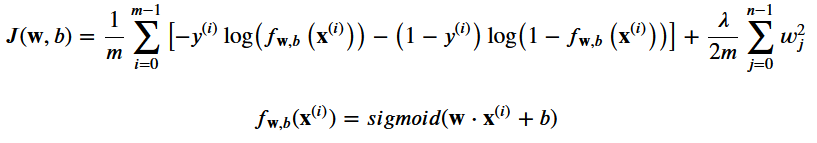

In [121]:
def cost_lr_reg(X,y,w,b,reg_par):
    """
    Computes cost of logistic function 

    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter, biased term
      reg_par (scalar) : regularization parameter
      
    Returns:
      J_wb (scalar): vaue of cost function
    """
    m = X.shape[0]
    z_wb = np.dot(X,w)+b
    f_wb = sigmoid(z_wb)
    # Cost for logistic regression
    cost = -(1/m)*(np.dot(np.log(f_wb),y)+np.dot(np.log(1-f_wb),1-y))
    # Cost of regularization
    reg_cost = (reg_par/(2*m))*np.dot(w,w)
    # Total cost
    J_wb = cost + reg_cost
    
    return J_wb

Computing the gradient with regularization:
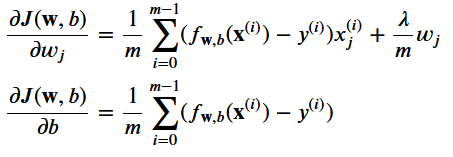

In [122]:
def compute_gradient_lr_reg(X,y,w,b,reg_par):
    """
    Computes gradient of logistic function 

    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter, biased term
      reg_par            : Regularization parameter

      
    Returns:
      J_wb (scalar): vaue of cost function
    """
    m = X.shape[0]
    w_t = w
    b_t = b
    z_wb = np.dot(X,w_t)+b_t
    f_wb = sigmoid(z_wb)
    
    # Estimation of parcial derivatives
    d_w = (1/m)*(np.dot(f_wb-y,X))+(reg_par/m)*w_t
    d_b = (1/m)*sum(f_wb-y)
    
    return d_w,d_b

Gradient descent agorithm:
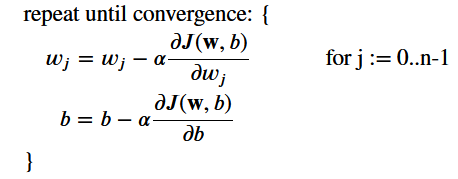

In [123]:
def gradient_descent_lr_reg(X, y, w_in, b_in, alpha, reg_par, num_iters): 
    """
    Performs batch gradient descent
    
    Args:
      X (ndarray (m,n)   : Data, m examples with n features
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): Initial values of model parameters  
      b_in (scalar)      : Initial values of model parameter
      alpha (float)      : Learning rate
      reg_par            : Regularization parameter
      num_iters (scalar) : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter 
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = w_in
    b = b_in
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_dw, dj_db = compute_gradient_lr_reg(X, y, w, b, reg_par)   

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               
     
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_lr_reg(X, y, w, b, reg_par) )
    """

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% np.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
       """

    return w, b, J_history         #return final w,b and J history for graphing


In [124]:
# Training the model
alpha = 3.625
iterations = 10000
reg_par = 1
w_t,b_t,error_t = gradient_descent_lr_reg(X_train,y_train,w,b,alpha,reg_par,iterations)
print(f'For alpha {alpha} -> error {error_t[-1]:.4f}\nw = {w_t}\nb = {b_t}')

For alpha 3.625 -> error 0.4010
w = [ 2.12802312  1.0494082   0.09979051  0.29740653 -0.19896003 -0.34946255
 -0.25538787  0.01206089 -0.344948   -0.37028188 -0.54704283 -0.13355462
 -0.76028207 -0.64138955  0.01462016  0.27880456 -0.08155846  0.275648
  0.4952225  -0.13634422  0.53408675 -0.64265192  0.         -0.31268986
 -0.31949757  0.51173152  0.          0.37799933  0.91837308  1.02466677
  0.19950984 -1.25797459 -0.20504817 -0.67952693  0.06657249  0.34316356
  0.17021874  0.38989577 -0.73741322  0.09254128 -0.32497862  0.12357944
  0.1807336  -0.30431303  0.99482507  0.14816611 -1.14299118  1.3575451
 -1.3575451 ]
b = -0.9144075285881313


In [125]:
# Use of updated w,b parameters to predict yhat values of the test set
yhat = sigmoid(np.dot(X_test,w_t)+b_t)

yhat[yhat>0.5] = 1
yhat[yhat<=0.5] = 0

print(f"The model has an accuracy of {(yhat == y_test).sum()*100/len(y_test):.2f} on the test set")

The model has an accuracy of 77.61 on the test set


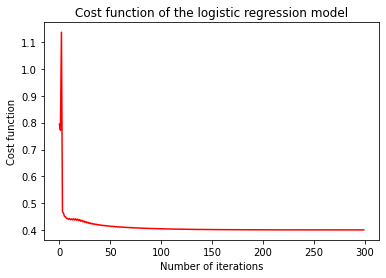

In [126]:
plt.plot(range(0,300),error_t[:300], 'r')
plt.title("Cost function of the logistic regression model")
plt.xlabel("Number of iterations")
plt.ylabel("Cost function")
plt.show()

From 150 iterations onwards the cost function stabilizes at around 0.3822.

Features are printed below with their parameter for the model - showing which features are more relevant to predict the outcome.

In [127]:
w_updated = pd.Series(w_t)
w_updated = w_updated.round(decimals=2)
s_columns = df_train.drop("Survived", axis = 1)
s_columns = s_columns.reset_index().columns.tolist()
s_columns = pd.Series(s_columns[1:])
df_weight = pd.concat([s_columns,w_updated], axis=1)
df_weight = df_weight.rename(columns = {0:"Feature",1:"Weight"}).set_index(["Feature"])
df_weight.to_csv("Weights.csv")
df_weight.transpose()

Feature,"age_(0, 5]","age_(5, 10]","age_(10, 15]","age_(15, 20]","age_(20, 25]","age_(25, 30]","age_(30, 35]","age_(35, 40]","age_(40, 45]","age_(45, 50]",...,Parch_5,Parch_6+,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
Weight,2.13,1.05,0.1,0.3,-0.2,-0.35,-0.26,0.01,-0.34,-0.37,...,0.09,-0.32,0.12,0.18,-0.3,0.99,0.15,-1.14,1.36,-1.36


#### Learning curve <a class="anchor" id="curve"></a> 

The learning curve compares the size of the training set used for the model with 2 values: the error of that training set and the error of the whole test set for that same model. This **shows if the model is underfitting or overfitting**.


For logistic regression, the error used is defined as:
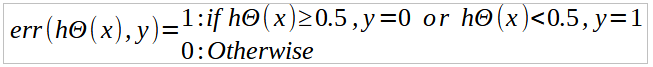
And the test error will be:
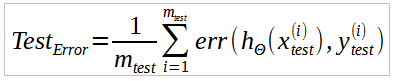

In this case, the model seemed to slightly overfit but, when removing or simplifying features, the test score got worse.

In [128]:
bins = np.arange(10,630,10) 
err_train = []
err_test = []
alpha = 3.625
iterations = 200
reg_par = 0

for interval in bins:
    w_temp,b_temp,error_temp = gradient_descent_lr_reg(X_train[:interval],y_train[:interval],w,b,alpha,reg_par,iterations)
    # error of the training set used for the model
    yhat_train = sigmoid(np.dot(X_train[:interval],w_temp)+b_temp)
    yhat_train[yhat_train>=0.5] = 1
    yhat_train[yhat_train<0.5] = 0
    err_train.append( (yhat_train != y_train[:interval]).sum()/interval )
    
    # error of the whole test set for the model
    yhat_test = sigmoid(np.dot(X_test,w_temp)+b_temp)
    yhat_test[yhat_test>=0.5] = 1
    yhat_test[yhat_test<0.5] = 0
    err_test.append( (yhat_test != y_test).sum()/len(y_test))

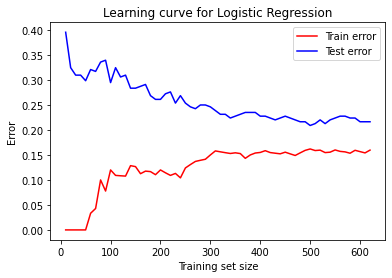

In [129]:
plt.plot(bins,err_train, 'r', label="Train error")
plt.plot(bins,err_test, 'b',label="Test error")
plt.title("Learning curve for Logistic Regression")
plt.xlabel("Training set size")
plt.ylabel("Error")
plt.legend(loc="upper right")
plt.show()

#### Prediction of the challenge set <a class="anchor" id="prediction"></a> 

This section outputs a csv file that is submitted to Kaggle and gives the accuracy score for the challenge set.

In [130]:
X_challenge = np.array(df_challenge.drop("Survived", axis = 1))

# Use of updated w,b parameters to predict survival for challenge set
yhat_challenge = sigmoid(np.dot(X_challenge,w_t)+b_t)

yhat_challenge[yhat_challenge>=0.5] = 1
yhat_challenge[yhat_challenge<0.5] = 0

print(f"In our challenge data the model predicted a survival rate of {yhat_challenge.sum()*100/len(yhat_challenge):.02f}%")

PassengerId = np.arange(892,1310)
df_sol = pd.DataFrame(yhat_challenge,columns=["Survived"]).set_index(PassengerId)
df_sol.index.name = "PassengerId"
df_sol = df_sol.astype({"Survived":int})

df_sol.to_csv("Titanic_solution.csv")

In our challenge data the model predicted a survival rate of 36.36%


**Challenge score with LR model: 0.77751**

### Logistic regression with scikit-learn <a class="anchor" id="scikit"></a> 

In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score

#### Algorithm with default parameters <a class="anchor" id="default"></a> 

In [132]:
# Instantiate the model (using the default parameters)
logreg = LogisticRegression()

# Fit the model with data
logreg.fit(X_train, y_train)

# Predictions for the training set
y_pred = logreg.predict(X_train)

# Matrix with a 2 component vector for each sample, with the probability of that sample being in class "0" or class "1"
y_predicted_prob = logreg.predict_proba(X_train)

print(f"In our challenge data the model predicted a survival rate of {y_pred.sum()*100/len(y_pred):.02f}%")

In our challenge data the model predicted a survival rate of 33.71%


In [133]:
print(f"Optimized parameters: {logreg.coef_}\n")
print(f"The score for the model is:\nTraining set:{logreg.score(X_train,y_train):.03f}\nTest set:{logreg.score(X_test,y_test):.03f}")

Optimized parameters: [[ 2.12801576  1.04946462  0.10004359  0.29730961 -0.19893741 -0.34949891
  -0.25540621  0.01201433 -0.3450996  -0.3703359  -0.54724478 -0.13369323
  -0.76030427 -0.64115395  0.01448918  0.27923453 -0.08128567  0.27595118
   0.49575755 -0.1359063   0.53470863 -0.64247617  0.         -0.31216869
  -0.31937677  0.51149465  0.          0.37824972  0.91840441  1.02468228
   0.19940819 -1.25779559 -0.20519778 -0.67983868  0.0663097   0.34299059
   0.16997384  0.38971581 -0.73696096  0.0925963  -0.32496244  0.12348674
   0.18049707 -0.30432097  0.99476997  0.14807185 -1.14317898  1.3573714
  -1.35770856]]

The score for the model is:
Training set:0.841
Test set:0.776


In [134]:
from sklearn.metrics import classification_report
# Classification report
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       396
           1       0.80      0.74      0.77       227

    accuracy                           0.84       623
   macro avg       0.83      0.82      0.83       623
weighted avg       0.84      0.84      0.84       623



In [135]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_train,y_pred)
cm

array([[355,  41],
       [ 58, 169]], dtype=int64)

In [136]:
# Normalized confusion matrix
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
cm_norm

array([[0.89646465, 0.10353535],
       [0.25550661, 0.74449339]])

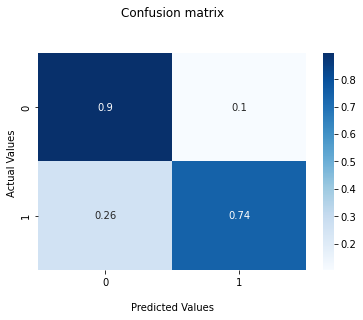

In [137]:
# Plot of confusion matrix
ax = sns.heatmap(cm_norm, annot=True, cmap='Blues')

ax.set_title('Confusion matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

In [138]:
# False positives
FP = cm.sum(axis=0) - np.diag(cm)

# False negatives
FN = cm.sum(axis=1) - np.diag(cm)

# True positives
TP = np.diag(cm)

# True negatives
TN = cm.sum() - (FP+FN+TP)

In [139]:
# Sensitivity, hit rate, recall or true positive rate
TPR = TP / (TP+FN)
print(f"The True Positive Rate is {TPR}, which is equivalent to the main diagonal of the confusion matrix")

# Precision or positive predictive value
PPV = TP / (TP+FP)
print(f"The precision is {PPV}, which tells how many of my predictions were correct (first number for 0's, second one for 1's)")

# False positive rate or false alarm rate
FPR = FP / (FP+TN)
print(f"The False Positive Rate is {FPR}: is thesecondary diagonal of the confusion matrix")

# False negative rate or Miss rate
FNR = FN / (FN+TP)
print(f"The False Negative Rate is {FNR}, which is the secondary diagonal of the confusion matrix") 

print(f"\nThe average TPR is {TPR.sum()/2}")
print(f"The average PPV is {PPV.sum()/2}")
print(f"The average FPR is {FPR.sum()/2}")
print(f"The average FPR is {FPR.sum()/2}")


The True Positive Rate is [0.89646465 0.74449339], which is equivalent to the main diagonal of the confusion matrix
The precision is [0.85956416 0.8047619 ], which tells how many of my predictions were correct (first number for 0's, second one for 1's)
The False Positive Rate is [0.25550661 0.10353535]: is thesecondary diagonal of the confusion matrix
The False Negative Rate is [0.10353535 0.25550661], which is the secondary diagonal of the confusion matrix

The average TPR is 0.8204790192675655
The average PPV is 0.8321630347054076
The average FPR is 0.17952098073243447
The average FPR is 0.17952098073243447


In [140]:
from sklearn.metrics import log_loss

# Log loss on training data
print(f"The log loss in the training data is {log_loss(y_train,y_predicted_prob)}")

# Log loss on testing data
y_predicted_prob_t = logreg.predict_proba(X_test)
print(f"The log loss in the test data is {log_loss(y_test,y_predicted_prob_t)}")


The log loss in the training data is 0.3846436257107737
The log loss in the test data is 0.5257640994975016


#### Algorithm with optimized parameter C <a class="anchor" id="optimized"></a> 

The CA of C parameter 1e-05 is 0.5708955223880597
The log loss of C parameter 1e-05 is 0.6916214750535807



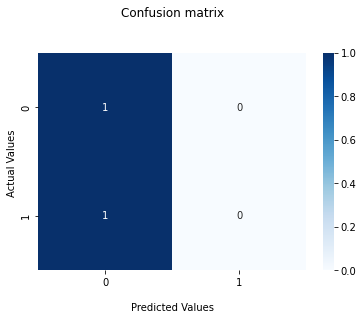

The CA of C parameter 3.359818286283781e-05 is 0.5708955223880597
The log loss of C parameter 3.359818286283781e-05 is 0.6909356540243091



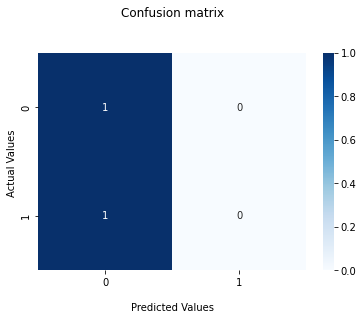

The CA of C parameter 0.00011288378916846884 is 0.5708955223880597
The log loss of C parameter 0.00011288378916846884 is 0.6886669271177065



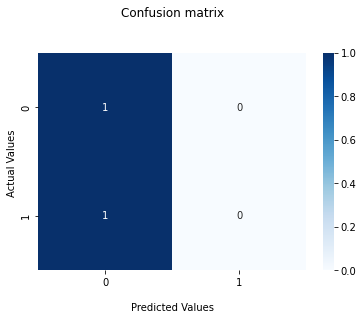

The CA of C parameter 0.000379269019073225 is 0.5708955223880597
The log loss of C parameter 0.000379269019073225 is 0.6814256885666982



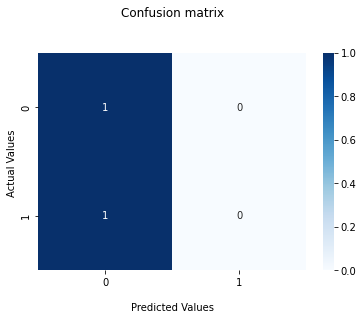

The CA of C parameter 0.0012742749857031334 is 0.5708955223880597
The log loss of C parameter 0.0012742749857031334 is 0.6607576165842711



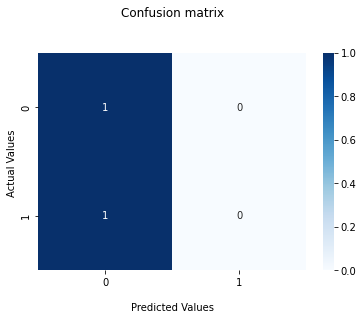

The CA of C parameter 0.004281332398719391 is 0.6305970149253731
The log loss of C parameter 0.004281332398719391 is 0.61693603895931



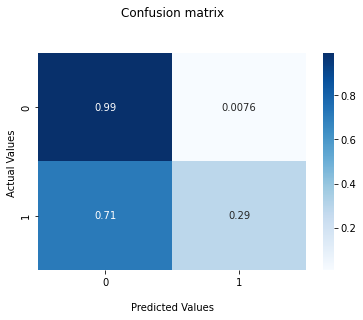

The CA of C parameter 0.01438449888287663 is 0.7276119402985075
The log loss of C parameter 0.01438449888287663 is 0.5635335904506099



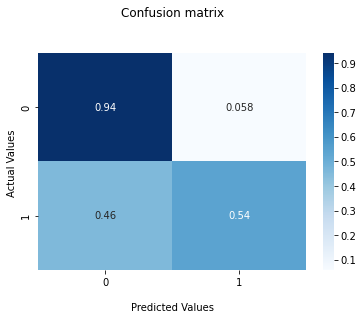

The CA of C parameter 0.04832930238571752 is 0.7425373134328358
The log loss of C parameter 0.04832930238571752 is 0.5304478183084831



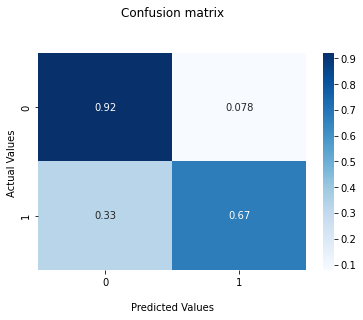

The CA of C parameter 0.1623776739188721 is 0.7574626865671642
The log loss of C parameter 0.1623776739188721 is 0.5208812584660168



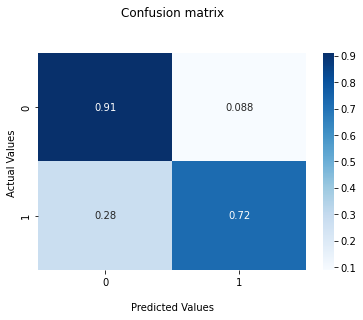

The CA of C parameter 0.5455594781168515 is 0.7723880597014925
The log loss of C parameter 0.5455594781168515 is 0.5228263484260463



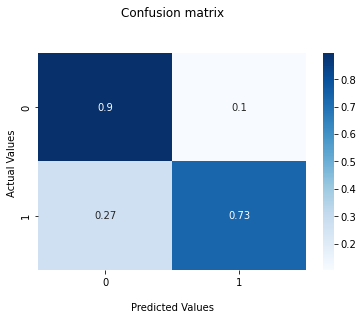

The CA of C parameter 1.8329807108324339 is 0.7798507462686567
The log loss of C parameter 1.8329807108324339 is 0.5296315259242174



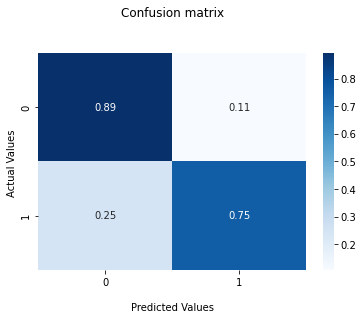

The CA of C parameter 6.1584821106602545 is 0.7835820895522388
The log loss of C parameter 6.1584821106602545 is 0.5393708522080302



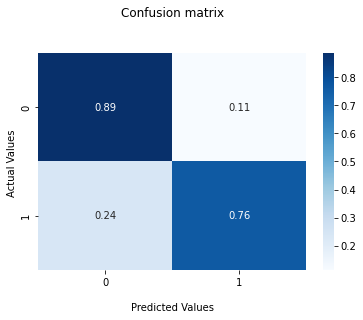

The CA of C parameter 20.6913808111479 is 0.7835820895522388
The log loss of C parameter 20.6913808111479 is 0.5492128042487221



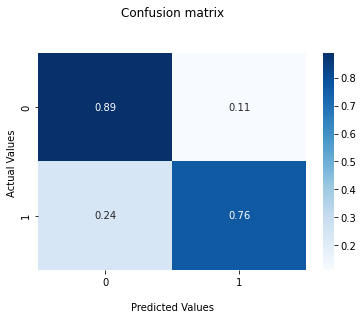

The CA of C parameter 69.51927961775606 is 0.7835820895522388
The log loss of C parameter 69.51927961775606 is 0.5582244443081943



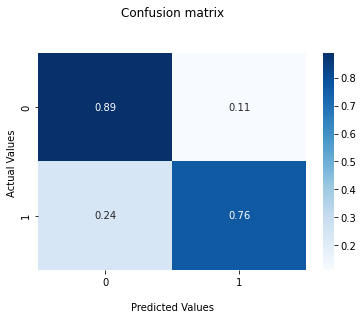

The CA of C parameter 233.57214690901213 is 0.7835820895522388
The log loss of C parameter 233.57214690901213 is 0.5666760606752779



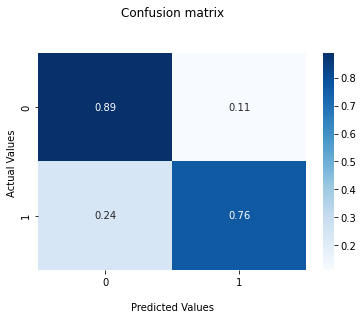

The CA of C parameter 784.7599703514607 is 0.7835820895522388
The log loss of C parameter 784.7599703514607 is 0.5750298606500865



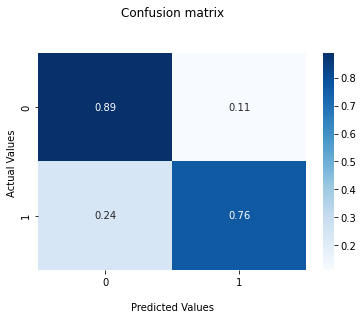

The CA of C parameter 2636.6508987303555 is 0.7835820895522388
The log loss of C parameter 2636.6508987303555 is 0.5826726927636972



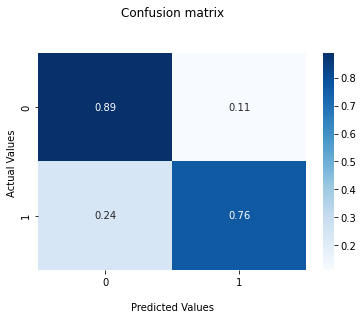

The CA of C parameter 8858.667904100832 is 0.7835820895522388
The log loss of C parameter 8858.667904100832 is 0.5909266730809902



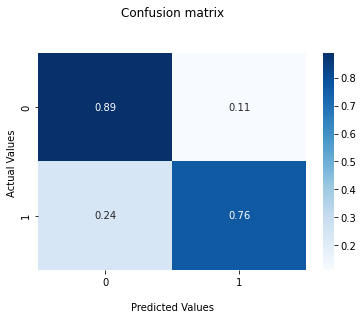

The CA of C parameter 29763.51441631313 is 0.7835820895522388
The log loss of C parameter 29763.51441631313 is 0.611304359186179



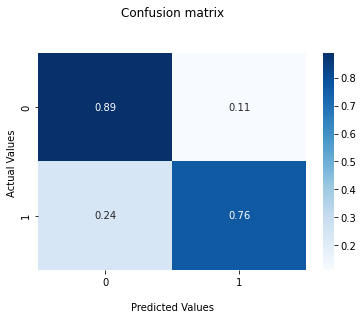

The CA of C parameter 100000.0 is 0.7835820895522388
The log loss of C parameter 100000.0 is 0.6174852743105805



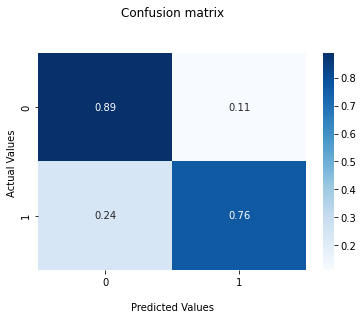

In [141]:
# Loop in order to find the optimum C value for the algorithm
C_List = np.geomspace(1e-5,1e5,num=20) # List of C values to test
CA = [] #Classification accuracy
logarithmic_loss = []

for c in C_List:
    logreg2 = LogisticRegression(C = c,max_iter = 1000)
    logreg2.fit(X_train,y_train)
    score = logreg2.score(X_test,y_test)
    CA.append(score)
    print(f"The CA of C parameter {c} is {score}")
    y_pred_prob_t = logreg2.predict_proba(X_test)
    logloss2 = log_loss(y_test,y_pred_prob_t)
    logarithmic_loss.append(logloss2)
    print(f"The log loss of C parameter {c} is {logloss2}\n")
    
    y_pred = logreg2.predict(X_train)
    cm = confusion_matrix(y_train,y_pred)
    cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
    ax = sns.heatmap(cm_norm, annot=True, cmap='Blues')

    ax.set_title('Confusion matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels([0,1])
    ax.yaxis.set_ticklabels([0,1])

    ## Display the visualization of the Confusion Matrix for each C value
    plt.show()

In [142]:
CA2 = np.array(CA)
logarithmic_loss2 = np.array(logarithmic_loss)
outcomes = zip(C_List,CA2,logarithmic_loss2)
df_outcomes = pd.DataFrame(outcomes,columns=["C","CA","Log_loss"])

In [143]:
df_outcomes

,C,CA,Log_loss
0,0.000010,0.570896,0.691621
1,0.000034,0.570896,0.690936
2,0.000113,0.570896,0.688667
3,0.000379,0.570896,0.681426
4,0.001274,0.570896,0.660758
5,0.004281,0.630597,0.616936
6,0.014384,0.727612,0.563534
7,0.048329,0.742537,0.530448
8,0.162378,0.757463,0.520881
9,0.545559,0.772388,0.522826


In [144]:
# Value with higher accuracy score and lowest log loss: C = 6.159
logreg_best = LogisticRegression(C =  6.159,max_iter = 1000)


# fit the model with data
logreg_best.fit(X, y)

yhat_sk = logreg_best.predict(X_challenge)

print(f"The score for the model is:\nTraining set:{logreg_best.score(X_train,y_train):.03f}\nTest set:{logreg_best.score(X_test,y_test):.03f}")

The score for the model is:
Training set:0.835
Test set:0.795


In [145]:
# Creation of csv file for challenge submission
df_sol_sk = pd.DataFrame(yhat_sk,columns=["Survived"]).set_index(PassengerId)
df_sol_sk.index.name = "PassengerId"
df_sol_sk = df_sol_sk.astype({"Survived":int})
df_sol_sk.to_csv("Titanic_solution_sk.csv")

**Challenge score with sklearn LR model: 0.76555**

### Testing with a Dummy classifier

Is good practice to test the model with a dummy classifier.

In [146]:
from sklearn.dummy import DummyClassifier

dummy_cls = DummyClassifier(strategy="most_frequent")
dummy_cls.fit(X_train,y_train)
score = dummy_cls.score(X_test,y_test)

y_pred_prob_t = dummy_cls.predict_proba(X_test)
logloss3 = log_loss(y_test,y_pred_prob_t)

print(f"Testing accuracy: {score}\nTesting log loss: {logloss3}")


Testing accuracy: 0.5708955223880597
Testing log loss: 14.820743602293764
